# Dispatch valuation

**TODO: Tidy up and encapsulate function definitions!**

Routines for dispatch validation comprising
* Evaluation of dispatch per energy carrier against historical one
* Evaluation of imports and exports
* Evaluation of storage operation
* Evaluation of energy not served and scarcity events

## Package imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict
from pommesevaluation.dispatch_validation import load_entsoe_german_generation_data

## Electrical bus data
### Read in

In [2]:
simulation_year = 2017
path_results = "./model_results/"
path_plots = "./plots/"
path_historical_production = "./data/production/"

model_file_name = f"dispatch_LP_start-{simulation_year}-01-01_364-days_simple_complete_production.csv"

In [3]:
buses_el = pd.read_csv(path_results + model_file_name, index_col=0)
historical_production = load_entsoe_german_generation_data(
    path=f"{path_historical_production}", year=simulation_year
)

### Filter and aggregate
* Filter for Germany
* Split into subsets for generation, export / import and storage

In [4]:
# Filter generation, exports and imports for Germany
bus_DE = buses_el[[col for col in buses_el.columns if "DE" in col]]

### Exports & imports
* Calculate overall exports and imports and net export
* Plot exports / imports by country
* Evaluate against historical exports and imports

In [5]:
# Filter imports and exports and calculate overall and net imports & exports
im_ex_DE = bus_DE[[col for col in bus_DE.columns if "link_" in col]].copy()
export_links = [col for col in im_ex_DE if "('DE_link_" in col]
import_links = [col for col in im_ex_DE if "DE_bus_el')" in col]
im_ex_DE["overall_exports"] = im_ex_DE[export_links].sum(axis=1)
im_ex_DE["overall_imports"] = -im_ex_DE[import_links].sum(axis=1)
im_ex_DE["net_export"] = im_ex_DE["overall_exports"] + im_ex_DE["overall_imports"]
im_ex_DE.index = pd.to_datetime(im_ex_DE.index)

In [6]:
export_links

["(('DE_link_AT', 'AT_bus_el'), 'flow')",
 "(('DE_link_BE', 'BE_bus_el'), 'flow')",
 "(('DE_link_CH', 'CH_bus_el'), 'flow')",
 "(('DE_link_CZ', 'CZ_bus_el'), 'flow')",
 "(('DE_link_DK1', 'DK1_bus_el'), 'flow')",
 "(('DE_link_DK2', 'DK2_bus_el'), 'flow')",
 "(('DE_link_FR', 'FR_bus_el'), 'flow')",
 "(('DE_link_NL', 'NL_bus_el'), 'flow')",
 "(('DE_link_NO2', 'NO2_bus_el'), 'flow')",
 "(('DE_link_PL', 'PL_bus_el'), 'flow')",
 "(('DE_link_SE4', 'SE4_bus_el'), 'flow')"]

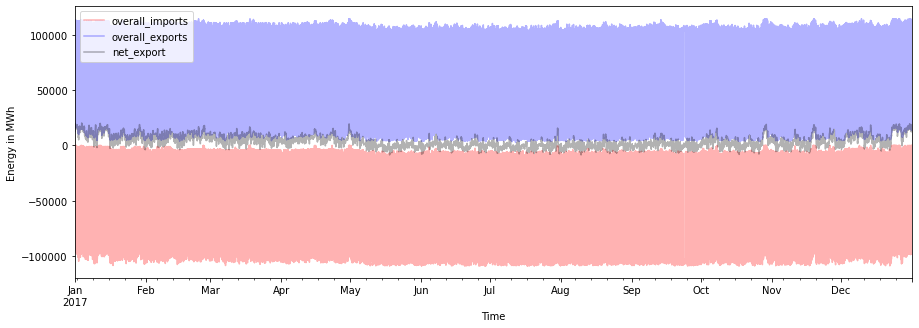

In [7]:
fig, ax = plt.subplots(figsize=(15, 5)) 

im_ex_DE[["overall_imports", "overall_exports", "net_export"]].plot(ax=ax, color=["red", "blue", "black"], alpha=0.3)
ax.set_xlabel("Time")
ax.set_ylabel("Energy in MWh")

plt.show()

In [8]:
im_ex_plot = im_ex_DE.copy()
im_ex_plot[import_links] *= -1
imports = {
    key: f"import_{key[3:5]}" 
    for key in import_links 
    if "DK" not in key and "SE" not in key
}
for key in import_links:
    if "DK" in key or "SE" in key:
        imports[key] = f"import_{key[3:6]}"

exports = {
    key: f"export_{key[11:13]}" 
    for key in export_links
    if "DK" not in key and "SE" not in key
}
for key in export_links:
    if "DK" in key or "SE" in key:
        exports[key] = f"export_{key[11:14]}"

im_ex_plot.rename(columns=imports, inplace=True)
im_ex_plot.rename(columns=exports, inplace=True)
im_ex_plot.drop(
    columns=[
        col for col in im_ex_plot.columns 
        if col not in imports.values() and col not in exports.values()
    ], 
    inplace=True
)

In [9]:
country_colors = {
    "FR": "blue",
    "CH": "red",
    "BE": "black",
    "CZ": "gray",
    "DK1": "lightblue",
    "DK2": "turquoise",
    "PL": "dimgray",
    "NL": "orange",
    "NO": "green",
    "SE4": "yellow",
    "AT": "purple"
}

In [10]:
colors_im = {
    f"import_{key}": val 
    for key, val in country_colors.items() 
    for col in im_ex_plot.columns if key in col
}
colors_ex = {
    f"export_{key}": val 
    for key, val in country_colors.items() 
    for col in im_ex_plot.columns if key in col
}
country_colors_im_ex = {**colors_im, **colors_ex}

In [11]:
# Remove exchange with Austria before market splitting in 2018
if simulation_year <= 2018:
    im_ex_plot.drop(columns=["export_AT", "import_AT"], inplace=True)
    country_colors.pop("AT")
    country_colors_im_ex.pop("export_AT")
    country_colors_im_ex.pop("import_AT")

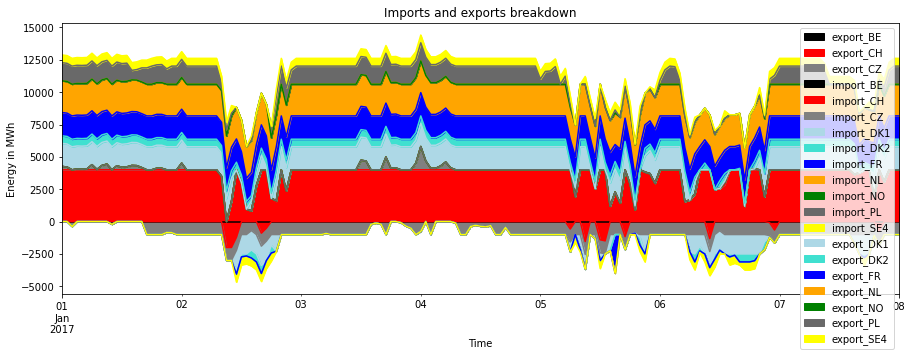

In [12]:
fig, ax = plt.subplots(figsize=(15, 5))
_ = im_ex_plot[:169].plot(kind="area", ax=ax, color=country_colors_im_ex)
_ = ax.set_title("Imports and exports breakdown")
_ = ax.set_xlabel("Time")
_ = ax.set_ylabel("Energy in MWh")
plt.show()

Show net exports / imports only

In [13]:
for country in country_colors.keys():
    im_ex_plot[f"net_export_{country}"] = (
        im_ex_plot[f"export_{country}"]
        + im_ex_plot[f"import_{country}"]
    )
im_ex_plot.drop(
    columns=[
        col for col in im_ex_plot.columns
        if "net_export" not in col
    ],
    inplace=True
)

In [17]:
for col in im_ex_plot.columns:
    im_ex_plot[f"{col}_pos"] = np.where(im_ex_plot[col] >= 0, im_ex_plot[col], 0)
    im_ex_plot[f"{col}_neg"] = np.where(im_ex_plot[col] < 0, im_ex_plot[col], 0)

In [18]:
im_ex_plot.drop(
    columns=[
        col for col in im_ex_plot
        if "pos" not in col and "neg" not in col
    ],
    inplace=True
)

In [20]:
country_colors_net_exports_pos = {
    f"net_export_{key}_pos": val 
    for key, val in country_colors.items() 
    for col in im_ex_plot.columns if key in col
}
country_colors_net_exports_neg = {
    f"net_export_{key}_neg": val 
    for key, val in country_colors.items() 
    for col in im_ex_plot.columns if key in col
} 
country_colors_net_exports = {
    **country_colors_net_exports_pos, **country_colors_net_exports_neg
}

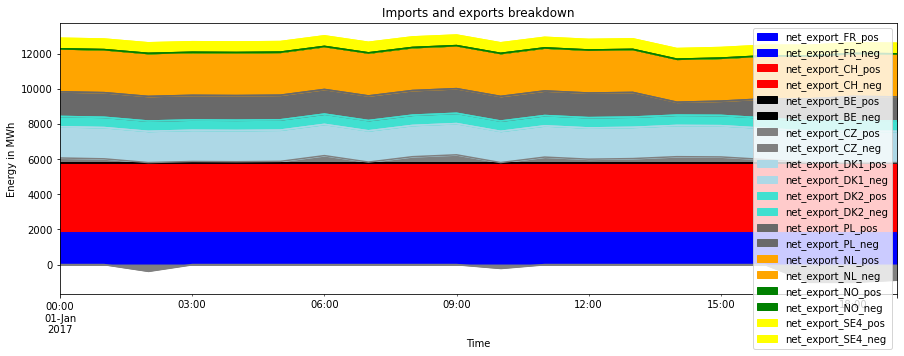

In [24]:
fig, ax = plt.subplots(figsize=(15, 5))
_ = im_ex_plot[:20].plot(kind="area", ax=ax, color=country_colors_net_exports)
_ = ax.set_title("Imports and exports breakdown")
_ = ax.set_xlabel("Time")
_ = ax.set_ylabel("Energy in MWh")
plt.show()

### Storage

In [ ]:
storage_DE = bus_DE[[col for col in bus_DE.columns if "storage" in col]]
storage_DE_renamed = storage_DE.rename(columns={
    "(('DE_bus_el', 'DE_storage_el_PHS'), 'flow')": "storage_in",
    "(('DE_storage_el_PHS', 'DE_bus_el'), 'flow')": "storage_out"
})
storage_DE_renamed["storage_in"] *= -1
storage_DE_renamed["net_storage"] = storage_DE_renamed["storage_out"] + storage_DE_renamed["storage_in"]
storage_DE_renamed.index = pd.to_datetime(storage_DE_renamed.index)

In [ ]:
fig, ax = plt.subplots(figsize=(15, 5))    


_ = ax.fill_between(
    storage_DE_renamed.index, 0, storage_DE_renamed.storage_in,
    step='post',
    facecolor='red',
    label="storage_in",
    alpha=1
)
_ = ax.fill_between(
    storage_DE_renamed.index, 0, storage_DE_renamed.storage_out,
    step='post',
    facecolor='blue',
    label="storage_out",
    alpha=1
)

_ = plt.axhline(y=0, color='gray', linestyle='-.', linewidth=.4)
_ = plt.title("Storage pattern")
_ = plt.tight_layout()
ax.set_xlabel("Time")
ax.set_ylabel("Energy in MWh")
_ = plt.legend()

plt.show()

### Power generation

In [ ]:
# Aggregate all generation units
power_generation_DE = bus_DE[[
    col for col in bus_DE.columns 
    if col not in im_ex_DE.columns
    and col not in storage_DE.columns
]]

# Drop demand, power prices and shortage
power_generation_DE = power_generation_DE.drop(
    columns=[
        "(('DE_bus_el', 'DE_sink_el_load'), 'flow')", 
        "(('DE_bus_el', 'None'), 'duals')",
        "(('DE_source_el_shortage', 'DE_bus_el'), 'flow')",
    ]
)

power_generation_DE["overall_generation"] = power_generation_DE.sum(axis=1)
power_generation_DE.index = pd.to_datetime(power_generation_DE.index)

In [ ]:
fuel_dict = {
    'ROR': 'Wasser',
    'biomass': 'Biomasse',
    'biomassEEG': 'Biomasse',
    'landfillgas': 'Deponiegas',
    'geothermal': 'Geothermie',
    'minegas': 'Grubengas',
    'larga': 'Klärgas',
    'windonshore': 'Windenergie an Land',
    'windoffshore': 'Windenergie auf See',
    'solarPV': 'Solare Strahlungsenergie',
    'uranium': 'Kernenergie',
    'lignite': 'Braunkohle',
    'hardcoal': 'Steinkohle',
    'waste': 'Abfall',
    'natgas': 'Erdgas',
    'otherfossil': 'Andere fossile',
    'mixedfuels': 'Mehrere fossile',
    'oil': 'Heizöl',
}

In [ ]:
colors = {
    'solarPV': '#fcb001',
    'windonshore': '#82cafc',
    'windoffshore': '#0504aa',
    'uranium': '#e50000',
    'lignite': '#7f2b0a',
    'otherfossil': '#d8dcd6',
    'hardcoal': '#000000',
    'waste': '#c04e01',
    'mixedfuels': '#a57e52',
    'biomass': '#15b01a',
    'geothermal': '#ff474c',
    'otherres': '#06c2ac',
    'minegas': '#650021',
    'natgas': '#929591',
    'oil': '#aaa662',
    'ROR': '#c79fef',
    'storage_el_out' : '#aaa543'
}

In [ ]:
# Group outputs by energy carrier
energy_sources_dict = OrderedDict()

for fuel in fuel_dict.keys():
    energy_sources_dict[fuel] = [
        entry for entry in power_generation_DE.columns.values if fuel in entry
    ]   
    
# Store the aggregated production results per energy source
generation = pd.DataFrame()
for key, val in energy_sources_dict.items():
    generation[key] = power_generation_DE[val].sum(axis = 1)

# Aggregate
generation["biomass"] = generation["biomass"] + generation["biomassEEG"]
generation["otherres"] = (
    generation["landfillgas"]
    + generation["larga"]
)

generation.drop(
    columns=[
        col for col in generation.columns
        if col not in colors.keys()
    ],
    inplace=True
)

generation["storage_el_out"] = storage_DE_renamed["storage_out"]

In [ ]:
fig, ax = plt.subplots(figsize=(15, 5))
_ = generation.iloc[4000:4369].plot(ax=ax, kind="area", color=colors)
_ = ax.set_xlabel("Time")
_ = ax.set_ylabel("Energy produced [MWh/h]")
_ = plt.legend(bbox_to_anchor=[1.02, 1.05])
plt.show()

### Compare generation againts historical

In [ ]:
overall_generation = pd.DataFrame(index=generation.columns)

In [ ]:
overall_generation["model"] = generation.sum()

In [ ]:
overall_generation["historical"] = historical_production.sum()

In [ ]:
historical_production.columns

In [ ]:
fig, ax = plt.subplots(figsize=(15,5))
_ = overall_generation.plot(kind="bar", ax=ax)
plt.show()

In [ ]:
len(power_generation_DE.columns)

## Analyze demand and net demand (after storage and exports / imports)

In [ ]:
demand_DE = bus_DE[["(('DE_bus_el', 'DE_sink_el_load'), 'flow')"]].rename(
    columns={
        "(('DE_bus_el', 'DE_sink_el_load'), 'flow')": "domestic_demand"
    }
)

In [ ]:
demand_DE

## Contrast demand and generation
* Calculate generation after net storage and net exports and compare with domestic demand
* Identify the difference, i.e. shortages
* Identify maximum shortage value and time

In [ ]:
balance = power_generation_DE[["overall_generation"]].copy()
balance["net_export"] = im_ex_DE["net_export"]
balance["net_storage"] = storage_DE_renamed["net_storage"]
balance["gen_ex_stor"] = balance["overall_generation"] + balance["net_storage"] - balance["net_export"]
balance["demand"] = demand_DE["domestic_demand"]
balance["delta"] = balance["gen_ex_stor"] - balance["demand"]

In [ ]:
balance["delta"].loc["2017-01-23 12:00":"2017-01-25"]

In [ ]:
# Identify scarcity situations
balance["delta"].loc[balance["delta"] < -0.1]

In [ ]:
bus_DE["(('DE_source_el_shortage', 'DE_bus_el'), 'flow')"].max()

In [ ]:
bus_DE["(('DE_source_el_shortage', 'DE_bus_el'), 'flow')"].idxmax()